In [1]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
val_transforms=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(0.49,0.248),

])

In [4]:
val_dataset = torchvision.datasets.DatasetFolder(
    root=r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\Processed\val",
    loader=load_file,
    extensions=("npy",),
    transform=val_transforms
)


In [5]:
temp_model=torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [8]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

        
            
    def forward(self, data):
        
      
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))

        print(avg_pool_output.shape)
        avg_pool_output_flattened = torch.flatten(avg_pool_output,1)
        print(avg_pool_output_flattened.shape)

     
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [10]:

ckpt_path = r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\logs\lightning_logs\version_5\checkpoints\best-auroc-epoch=25-val_acc=0.8171-val_auroc=0.8936.ckpt"

model = PneumoniaModel.load_from_checkpoint(ckpt_path, strict=False)


In [11]:
%pip install pydicom


Note: you may need to restart the kernel to use updated packages.


Example of patients with pneumonia: 6012
Example of patient: 00f08de1-517e-4652-a04f-d1dc9ee48593


<IPython.core.display.Javascript object>

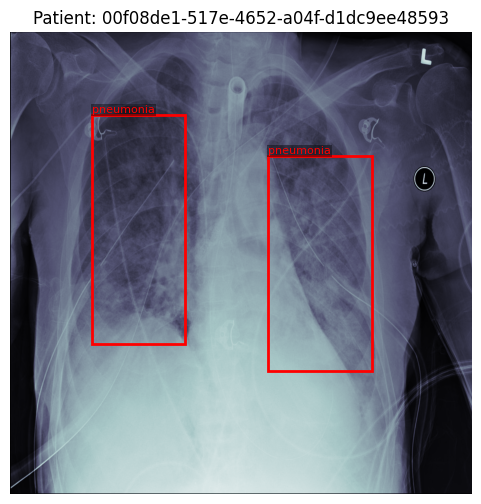

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
from IPython.display import display 

Labels_Csv = r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv"
Images_Dir = r"C:\Users\milos\Projects\rsna-pneumonia-detection-challenge\stage_2_train_images"

df = pd.read_csv(Labels_Csv)
df_pos = df[df["Target"] == 1].copy()

print("Example of patients with pneumonia:", df_pos["patientId"].nunique())

def show_image_with_bboxes(patient_id):
    rows = df[df["patientId"] == patient_id]

    dcm_path = os.path.join(Images_Dir, f"{patient_id}.dcm")
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array.astype(np.float32)

   
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

 
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(img, cmap="bone")
    ax.set_title(f"Patient: {patient_id}")
    ax.axis("off")

   
    for _, r in rows.iterrows():
        if r["Target"] == 1:
            x, y, w, h = r["x"], r["y"], r["width"], r["height"]
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2,
                edgecolor="red",
                facecolor="none"
            )
            ax.add_patch(rect)

            ax.text(
                x,
                y - 5,
                "pneumonia",
                color="red",
                fontsize=8,
                bbox=dict(facecolor="black", alpha=0.4, edgecolor="none", pad=1)
            )

    
    return fig


example_id = df_pos["patientId"].iloc[9]
print("Example of patient:", example_id)

fig = show_image_with_bboxes(example_id)
display(fig)  
plt.close(fig)


